In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
# pykat only used for setting up nice plots
# import pykat
# pykat.init_pykat_plotting(fmts=['png'])

import pandas as pd
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.signal

import numpy.random

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import peak_finder as pkf
import general_funs as gef

def lorentzian(fwhm,x,x0=0):
    return ((np.pi*fwhm)/2) * 1/(2*np.pi) * fwhm/((x-x0)**2+(0.5*fwhm)**2)

def lorentzian(fwhm,x,x0=0):
    return (0.5*fwhm)**2/((x-x0)**2+(0.5*fwhm)**2)

Text(0, 0.5, 'OMC DCPD Sum [W]')

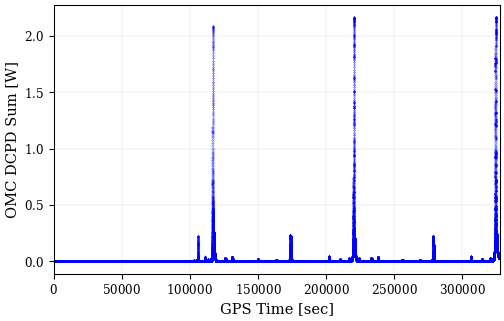

In [192]:
df1 = pd.read_csv('./dig_for_02.csv')
y = df1['data'].to_numpy()
t = df1['time'].to_numpy()
dt = t[1] - t[0]

plt.plot(y, '.', ms=0.4)
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')

In [191]:
y_slc = y[160000:285000]+3.7e-4
t_slc = np.arange(len(y_slc))*dt

In [155]:
sos = scipy.signal.butter(4, 0.1, 'low', output='sos')
y_filt = scipy.signal.sosfiltfilt(sos, y_slc)

In [156]:
_, pk_ind = pkf.my_peak_det_bs(y_filt, num_peaks=3)

In [157]:
tem_02, tem_00, tem_02_b = pk_ind
mode_sep = (tem_00 - tem_02)/2

tem_01 = pkf.win_max_find_2(y_filt, tem_00 - mode_sep)
tem_04_b = pkf.win_max_find_2(y_filt, tem_02_b - mode_sep*2)

0.6076
0.5
0.9076
0.5


/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../LHO_full_OMC_scan.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../LHO_full_OMC_scan.pdf


0

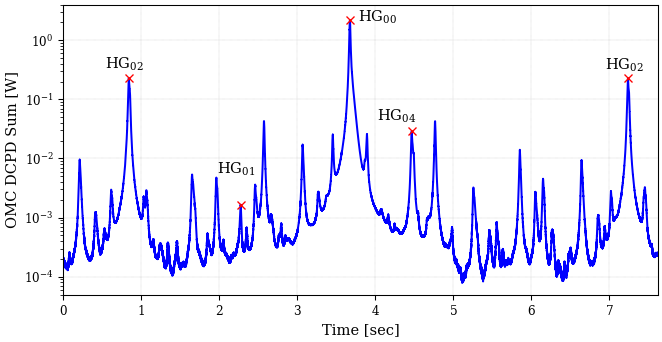

In [203]:
fig = plt.figure(figsize=[8,4])
plt.semilogy(t_slc, y_slc)
plt.plot(t_slc[tem_02], y_slc[tem_02],'x',c='r')
plt.plot(t_slc[tem_00], y_slc[tem_00],'x',c='r')
plt.plot(t_slc[tem_01], y_slc[tem_01],'x',c='r')
plt.plot(t_slc[tem_04_b], y_slc[tem_04_b],'x',c='r')
plt.plot(t_slc[tem_02_b], y_slc[tem_02_b],'x',c='r')

plt.text(t_slc[tem_02] - 0.3, y_slc[tem_02]+ 1e-1, 'HG$_{02}$')
plt.text(t_slc[tem_00] + 0.1, y_slc[tem_00] - 0.1, 'HG$_{00}$')
plt.text(t_slc[tem_01] - 0.3 , y_slc[tem_01] + 4e-3, 'HG$_{01}$')
plt.text(t_slc[tem_04_b] - 0.45, y_slc[tem_04_b] + 1.5e-2, 'HG$_{04}$')
plt.text(t_slc[tem_02_b] - 0.3, y_slc[tem_02_b] + 1e-1, 'HG$_{02}$')

plt.ylabel('OMC DCPD Sum [W]')
plt.xlabel('Time [sec]')
plt.ylim([5e-5, 4])

# mpf.thesis_savefig(fig, '../LHO_full_OMC_scan', resize=False)

In [6]:
t_offset = df1['time'][0]
df1['time'] -= t_offset
t0 = df1['time'][0]

0.0009842555


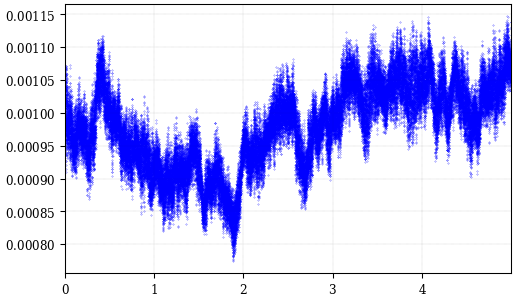

In [7]:
df_floor = df1[(df1['time']<t0+5)]
plt.plot(df_floor['time'],df_floor['data'],'.',ms=0.4)
omc_floor = df_floor['data'].median()
print(omc_floor)

In [8]:
df_floor_sub = df1.copy()
df_floor_sub['data']-= omc_floor
print(df_floor_sub['data'].median())

-0.000102275


In [9]:
df_second_peak = df_floor_sub[(df_floor_sub['time']>t0+16.88) & (df_floor_sub['time']<t0+17.14)]

Text(0, 0.5, 'OMC DCPD Sum [W]')

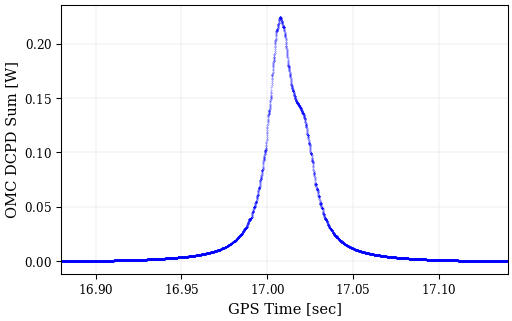

In [10]:
plt.plot(df_second_peak['time'],df_second_peak['data'],'.',ms=0.4)
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')

In [11]:
peak_max = df_second_peak[df_second_peak['data'] == df_second_peak['data'].max()]
P0 = peak_max['data'].values
t0 = peak_max['time'].values
fwhm_sel = df_second_peak[(abs(df_second_peak['data'] - P0/2))<5.3e-4].reset_index(drop=True)
fwhm = fwhm_sel['time'].loc[1] - fwhm_sel['time'].loc[0]
fwhm

0.024353504180908203

In [12]:
# write out the cutout to separate file
#df_second_peak.to_csv('second_order.csv',index=False)

In [13]:
t = df_second_peak['time'].values

# f_plot2 = lambda x,t: lorentzian(x[0],t,x0=x[1])
# f_plot = lambda x: x[2]*lorentzian(x[0],t,x0=x[1])
# f = lambda x: sum( abs(x[2]*lorentzian(x[0],t,x0=x[1])-df_second_peak['data']))

In [14]:
def model(x,retrun_res=True):
    fwhm,t0,a0,y0,yerr = x
    n = len(t)
    model = y0 + a0*lorentzian(fwhm,t,x0=t0)
    sigma_2 = yerr**2
    res = 0.5 * sum((model - df_second_peak['data'])**2)/sigma_2 + n*np.log((2*np.pi)*sigma_2)
    if retrun_res:
        return res
    else:
        return model

In [15]:
# perform fit

# a0 = P0 / (2/(np.pi*fwhm))
a0 = P0
x0 = [0.04,t0+70.61,0.01]
x0 = [fwhm,t0,a0]
# soln = sp.optimize.minimize(f,x0,method='Nelder-Mead',options={'xatol' : 1e-6,'adaptive':True})

x0 = [fwhm,t0,a0,0,0]
soln = sp.optimize.minimize(model,x0,method='Nelder-Mead',options={'xatol' : 1e-6,'adaptive':True})
soln

/home/alexei/miniconda3/envs/alexei/lib/python3.9/site-packages/scipy/optimize/_minimize.py:496: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.asarray(x0)
/tmp/ipykernel_5960/1496995375.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  res = 0.5 * sum((model - df_second_peak['data'])**2)/sigma_2 + n*np.log((2*np.pi)*sigma_2)
/tmp/ipykernel_5960/1496995375.py:6: RuntimeWarning: divide by zero encountered in log
  res = 0.5 * sum((model - df_second_peak['data'])**2)/sigma_2 + n*np.log((2*np.pi)*sigma_2)
/tmp/ipykernel_5960/1496995375.py:6: RuntimeWarning: invalid value encountered in double_scalars
  res = 0.5 * sum((model - df_second_peak['data'])**2)/sigma_2 + n*np.log((2*np.pi)*sigma_2)


 final_simplex: (array([[  2.36537151e-02,   1.70100181e+01,   2.17606152e-01,
         -3.94286886e-03,   5.18495977e-03],
       [  2.36536253e-02,   1.70100181e+01,   2.17606975e-01,
         -3.94287086e-03,   5.18491882e-03],
       [  2.36538301e-02,   1.70100182e+01,   2.17606200e-01,
         -3.94300605e-03,   5.18488996e-03],
       [  2.36536572e-02,   1.70100181e+01,   2.17606322e-01,
         -3.94291104e-03,   5.18487594e-03],
       [  2.36538518e-02,   1.70100181e+01,   2.17606106e-01,
         -3.94305370e-03,   5.18491213e-03],
       [  2.36536426e-02,   1.70100181e+01,   2.17607068e-01,
         -3.94279935e-03,   5.18487954e-03]]), array([-32742.90782479, -32742.9078244 , -32742.90782434, -32742.90782399,
       -32742.90782341, -32742.90782313]))
           fun: -32742.907824791786
       message: 'Optimization terminated successfully.'
          nfev: 738
           nit: 405
        status: 0
       success: True
             x: array([  2.36537151e-02,   1.70100

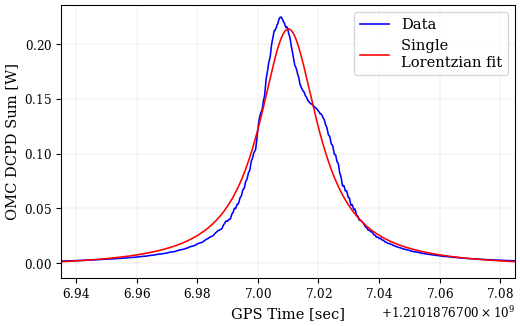

In [16]:
t_arr = np.array(df_second_peak['time']) + t_offset
t0 = t_arr[0]
t1 = t_arr[-1]

# plot fit

fig1 = plt.figure(figsize=mpf.thesis_figsize())
# plt.plot(df_second_peak['time'],f_plot([0.04,t0+70.61,0.01]),'.',ms=0.4)
plt.plot(t_arr, df_second_peak['data'], ms=0.4, label='Data')
plt.plot(t_arr, model(soln.x,False), ms=0.4, label='Single \nLorentzian fit')
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')
plt.xlim(t0+0.055,t1-0.055)
plt.legend()
# mpf.outer_legend()

fig1.savefig('single_fit.png',dpi=300)
fig1.savefig('single_fit.pdf',dpi=300)

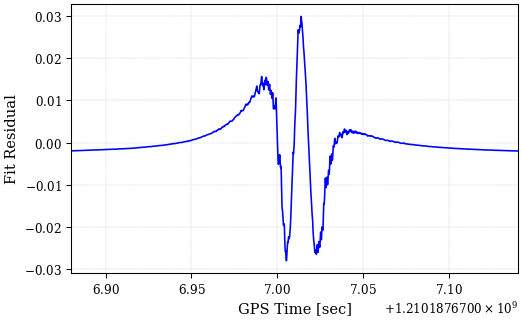

In [17]:
# plot residual

fig1_re = plt.figure()
plt.plot(df_second_peak['time']+t_offset,model(soln.x,False)-df_second_peak['data'],ms=0.4)
plt.xlabel('GPS Time [sec]')
plt.ylabel('Fit Residual')

fig1_re.savefig('single_fit_residual.png',dpi=300)
fig1_re.savefig('single_fit_residual.pdf',dpi=300)

# Fitting 2 lorentzians (0,2) and (2,0)

In [18]:
# f2_plot = lambda x: x[2]*lorentzian(x[0],t,x0=x[1]-x[4]) + x[3]*lorentzian(x[0],t,x0=x[1]+x[4])
# f2 = lambda x: sum(abs(f2_plot(x)-df_second_peak['data']))

In [19]:
def model2(x,retrun_res=True,simulate_noise=False):
#     print(x)
    fwhm,t0,a02,a20,del_t,y0,yerr = x
    if fwhm<0 or t0 < 0 or a02 < 0 or a20 < 0 or del_t < 0 or yerr < 0:
        return np.inf
    n = len(t)
    model = y0 + a02*lorentzian(fwhm,t,x0=t0-del_t) + a20*lorentzian(fwhm,t,x0=t0+del_t)
    sigma_2 = yerr**2
    res = 0.5 * sum((model - df_second_peak['data'])**2/sigma_2 + n*np.log((2*np.pi)*sigma_2))
    if retrun_res:
        return res
    else:
        return model + np.random.randn(n)*abs(yerr)*simulate_noise

In [20]:
# guess the separation
del_t = 0.007
fwhm,t0,a0,y0,yerr = soln.x
yerr = 1e-5
y0 = 1e-6
x0_2 = [fwhm,t0,a0,a0/3,del_t,y0,yerr]

# x0_2 = soln.x.tolist()+[soln.x[-1],del_t]
# soln2 = sp.optimize.minimize(f2,x0_2,method='Nelder-Mead',options={'xatol' : 1e-6, 'maxiter': 1e4,'adaptive':True})

soln2 = sp.optimize.minimize(model2,x0_2,method='Nelder-Mead',options={'xatol' : 1e-6, 'maxiter': 1e5,'adaptive':True})


soln2

 final_simplex: (array([[  1.57605609e-02,   1.70141823e+01,   2.04444801e-01,
          8.63316553e-02,   6.98374939e-03,  -1.25937593e-03,
          9.63948129e-06],
       [  1.57605605e-02,   1.70141823e+01,   2.04444815e-01,
          8.63316466e-02,   6.98375011e-03,  -1.25937619e-03,
          9.63948647e-06],
       [  1.57605601e-02,   1.70141823e+01,   2.04444817e-01,
          8.63316467e-02,   6.98374989e-03,  -1.25937696e-03,
          9.63947490e-06],
       [  1.57605604e-02,   1.70141823e+01,   2.04444803e-01,
          8.63316511e-02,   6.98374985e-03,  -1.25937475e-03,
          9.63947560e-06],
       [  1.57605604e-02,   1.70141823e+01,   2.04444812e-01,
          8.63316444e-02,   6.98375004e-03,  -1.25937603e-03,
          9.63949201e-06],
       [  1.57605590e-02,   1.70141823e+01,   2.04444809e-01,
          8.63316646e-02,   6.98374932e-03,  -1.25937433e-03,
          9.63947788e-06],
       [  1.57605600e-02,   1.70141823e+01,   2.04444816e-01,
          8.633

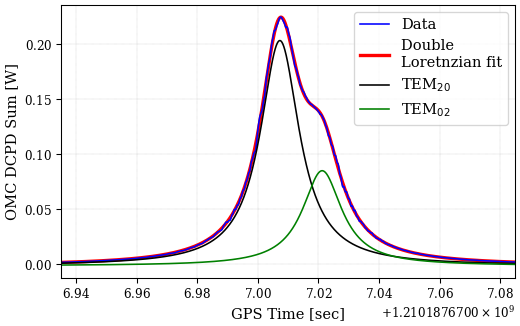

In [21]:
t_arr = np.array(df_second_peak['time']) + t_offset
t0 = t_arr[0]
t1 = t_arr[-1]

x = soln2.x

# plot fit

# fig2 = plt.figure(figsize=[8,5])
fig2 = plt.figure(figsize=mpf.thesis_figsize())

plt.plot(t_arr, df_second_peak['data'], ms=0.4, label='Data')
plt.plot(t_arr, model2(soln2.x,False), ms=0.4, lw=2.5, label='Double \nLoretnzian fit', zorder=-99)
plt.plot(t_arr, x[5]+x[2]*lorentzian(x[0],t,x0=x[1]-x[4]), label='TEM$_{20}$')
plt.plot(t_arr, x[5]+x[3]*lorentzian(x[0],t,x0=x[1]+x[4]), label='TEM$_{02}$')
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')
plt.xlim(t0+0.055,t1-0.055)
plt.legend()
# leg = plt.legend(loc='lower left', bbox_to_anchor=(0.07, 1.03, 0.86, 1), ncol=2 , mode='expand', borderaxespad=0)

fig2.savefig('double_fit.png',dpi=300)
fig2.savefig('double_fit.pdf',dpi=300)

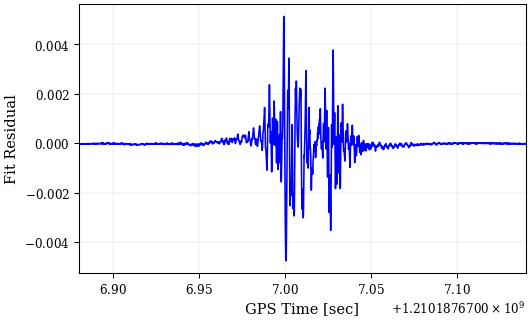

In [22]:
# plot residual

fig2_re = plt.figure()

plt.plot(df_second_peak['time']+t_offset,model2(soln2.x,False)-df_second_peak['data'],ms=0.4)
plt.xlabel('GPS Time [sec]')
plt.ylabel('Fit Residual')

fig2_re.savefig('double_fit_residual.png',dpi=300)
fig2_re.savefig('double_fit_residual.pdf',dpi=300)

In [23]:
soln2.x

array([  1.57605609e-02,   1.70141823e+01,   2.04444801e-01,
         8.63316553e-02,   6.98374939e-03,  -1.25937593e-03,
         9.63948129e-06])

In [25]:
soln2.x[0]/soln2.x[4]*2

4.5134955588907388

In [23]:
a00 = 2.17 # pulled separately from the same scan
mm = lambda mx,my : 1-np.sqrt((1-2*mx)*(1-2*my))
mm2 = lambda mx,my : (2*mx+2*my)/2
a02_2 = soln2.x[2]
a20_2 = soln2.x[3]
print(a02_2)
print(a20_2)
print()
print(mm(a02_2/a00,a20_2/a00))
print(mm2(a02_2/a00,a20_2/a00))
a2 = np.max(df_second_peak['data'])
print('naive mismatch from single peak = ',a2/a00*1.23)

0.20444465442610177
0.08633161915626703

0.13571049259213652
0.133998282756852
naive mismatch from single peak =  0.12727424688248848


# Fitting 3 lorentzians (0,2), (2,0), (1,1)

In [24]:
def model3(x,retrun_res=True,simulate_noise=False):
#     print(x)
    fwhm,t0,a02,a20,a11,del_t,y0,yerr = x
    if fwhm<0 or t0 < 0 or a02 < 0 or a20 < 0 or a11 < 0 or del_t < 0 or yerr < 0:
        return np.inf
    n = len(t)
    model = y0 + a02*lorentzian(fwhm,t,x0=t0-del_t) + a20*lorentzian(fwhm,t,x0=t0+del_t) + a11*lorentzian(fwhm,t,x0=t0)
    sigma_2 = yerr**2
    res = 0.5 * sum((model - df_second_peak['data'])**2/sigma_2 + n*np.log((2*np.pi)*sigma_2))
    if retrun_res:
        return res
    else:
        return model + np.random.randn(n)*abs(yerr)

In [25]:
f3_plot = lambda x: x[2]*lorentzian(x[0],t,x0=x[1]-x[4]) + x[3]*lorentzian(x[0],t,x0=x[1]+x[4]) + x[5]*lorentzian(x[0],t,x0=x[1])
f3 = lambda x: sum(abs(f3_plot(x)-df_second_peak['data']))

a11 = 6e-04 # a guess

x0_3 = soln2.x.tolist()+[a11]
# x0_3 = [0.01,t0+70.61,1e-3,1e-3,1e-3,1e-3]

fwhm,t0,a02,a20,del_t,y0,yerr = x
x0_3 = [fwhm,t0,a02,a20,a11,del_t,y0,yerr]

soln3 = sp.optimize.minimize(model3,x0_3,method='Nelder-Mead',options={'xatol' : 1e-6,'maxiter': 1e4, 'adaptive': True})
soln3

 final_simplex: (array([[ 1.56385924e-02,  1.70142220e+01,  2.01625587e-01,
         8.38499945e-02,  6.92229206e-03,  7.11483351e-03,
        -1.20887587e-03,  9.47001510e-06],
       [ 1.56385897e-02,  1.70142220e+01,  2.01625546e-01,
         8.38499426e-02,  6.92242772e-03,  7.11483597e-03,
        -1.20887463e-03,  9.47000517e-06],
       [ 1.56385905e-02,  1.70142220e+01,  2.01625550e-01,
         8.38499497e-02,  6.92240814e-03,  7.11483629e-03,
        -1.20887530e-03,  9.46999924e-06],
       [ 1.56385905e-02,  1.70142220e+01,  2.01625557e-01,
         8.38499540e-02,  6.92240163e-03,  7.11483590e-03,
        -1.20887663e-03,  9.47002723e-06],
       [ 1.56385916e-02,  1.70142220e+01,  2.01625576e-01,
         8.38499808e-02,  6.92233529e-03,  7.11483467e-03,
        -1.20887434e-03,  9.47002326e-06],
       [ 1.56385904e-02,  1.70142220e+01,  2.01625580e-01,
         8.38499707e-02,  6.92235429e-03,  7.11483503e-03,
        -1.20887472e-03,  9.47001745e-06],
       [ 1.563858

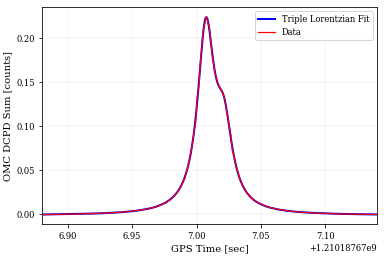

In [26]:
fig3 = plt.figure()

plt.plot(df_second_peak['time']+t_offset,model3(soln3.x,False),ms=0.4,lw=2)
plt.plot(df_second_peak['time']+t_offset,df_second_peak['data'],ms=0.6)
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [counts]')
plt.legend(['Triple Lorentzian Fit','Data'])

fig3.savefig('triple_fit.png',dpi=300)

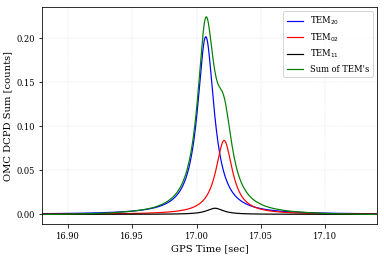

In [27]:
fig3_s = plt.figure()

fwhm,t0,a02,a20,a11,del_t,y0,yerr = soln3.x
plt.plot(df_second_peak['time'],a02*lorentzian(fwhm,t,x0=t0-del_t))
plt.plot(df_second_peak['time'],a20*lorentzian(fwhm,t,x0=t0+del_t))
plt.plot(df_second_peak['time'],a11*lorentzian(fwhm,t,x0=t0))
plt.plot(df_second_peak['time'],model3(soln3.x,False))
plt.xlabel('GPS Time [sec]')
plt.ylabel('OMC DCPD Sum [counts]')
plt.legend(['TEM$_{20}$','TEM$_{02}$','TEM$_{11}$',"Sum of TEM's"])

fig3_s.savefig('triple_fit_decomp.png',dpi=300)

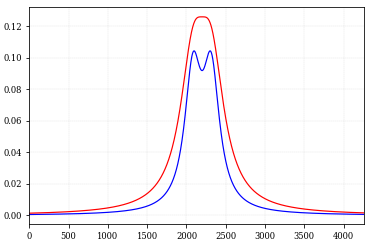

In [28]:
plt.plot(a20*lorentzian(fwhm,t,x0=t0+del_t)+a20*lorentzian(fwhm,t,x0=t0-del_t))
plt.plot(a20*lorentzian(del_t*2*np.sqrt(3),t,x0=t0+del_t)+a20*lorentzian(del_t*2*np.sqrt(3),t,x0=t0-del_t))

In [29]:
del_t*2/fwhm

0.9099071501574415

In [30]:
del_t*np.sqrt(3)

0.012323253129029058

In [31]:
del_t/(del_t*np.sqrt(3))

0.5773502691896257

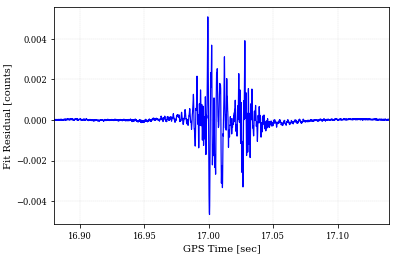

In [32]:
fig3_re = plt.figure()

plt.plot(df_second_peak['time'],model3(soln3.x,False)-df_second_peak['data'],ms=0.4)
plt.xlabel('GPS Time [sec]')
plt.ylabel('Fit Residual [counts]')

fig3_re.savefig('triple_fit_residual.png',dpi=300)

In [33]:
a02_3 = a02
a20_3 = a20
a11_3 = a11
print(a02_3)
print(a20_3)
print(a11_3)
print()
print('astigmatic mismatch')
print(mm(a02_3/a00,a20_3/a00))
print(mm2(a02_3/a00,a20_3/a00))
print()
print('mismatch error from not accounting for (1,1) mode =', mm(a02_2/a00,a20_2/a00)-mm(a02_3/a00,a20_3/a00))
a2 = np.max(df_second_peak['data'])
print('naive mismatch from single peak = ',a2/a00*1.23)

0.20162558702429706
0.08384999453713973
0.006922292062611211

astigmatic mismatch
0.13325320043966093
0.13155556753983264

mismatch error from not accounting for (1,1) mode = 0.0024572921524755875
naive mismatch from single peak =  0.12727424688248848
